In [1]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

(ch:pa_cleaning_aqs)=
# Wrangling and Cleaning AQS Sensor Data

Now that we have located sensors that are near each other, we are ready to wrangle and clean the files that contain the measurement data for the sites. We demonstrate the tasks involved for one sensor from the AQS and its matching sensor from PurpleAir. We picked a pair located in Sacramento, California. The AQS sensor ID is
`06-067-0010`, and the PurpleAir sensor name is `AMTS_TESTINGA`.

The AQS provides a website and API to download sensor data[^aqs_api].
To match Barkjohn's analysis, we downloaded the daily measurements from May 20, 2018 to Dec 29, 2019 into the
`data/aqs_06-067-0010.csv` file. Let's begin by loading this file into a `pandas` `DataFrame`.

[^aqs_api]: https://aqs.epa.gov/aqsweb/documents/data_api.html

In [9]:
aqs_full = pd.read_csv('data/aqs_06-067-0010.csv')
aqs_full.shape

(2268, 31)

As before, this data frame has too many columns to display in the notebook so 
we display columns names. 

In [10]:
aqs_full.columns

Index(['state_code', 'county_code', 'site_number', 'parameter_code', 'poc',
       'latitude', 'longitude', 'datum', 'parameter', 'sample_duration',
       'pollutant_standard', 'date_local', 'units_of_measure', 'event_type',
       'observation_count', 'observation_percent', 'validity_indicator',
       'arithmetic_mean', 'first_max_value', 'first_max_hour', 'aqi',
       'method_code', 'method', 'local_site_name', 'site_address', 'state',
       'county', 'city', 'cbsa_code', 'cbsa', 'date_of_last_change'],
      dtype='object')

From the data dictionary for this data[^aqs_dict], we find out that the
`arithmetic_mean` column corresponds to the actual PM2.5 measurements. Some AQS
sensors take a measurement every hour. 
For our analysis, we downloaded the 24-hour averages (the arithmetic mean) of the
hourly sensor measurements.

[^aqs_dict]: https://aqs.epa.gov/aqsweb/airdata/FileFormats.html#_hourly_data_files

Let's begin with some quality checks, and clean the data where necessary.
We focus on checks related to scope and quality of values: 

1. Check and correct the granularity of the data.
1. Remove unneeded columns.
1. Check values in the `date_local` column.
1. Check values in the `arithmetic_mean` column.

For the sake of brevity, we've chosen a few important quality checks that
specifically reinforce ideas we've covered in data wrangling, EDA, and visualization.

## Checking Granularity

We would like each row of our data to correspond to a single date with an average
PM2.5 reading for that date. As we saw earlier, a simple way to check is to see whether there are repeat values in the `date_local` column. 

In [11]:
aqs_full['date_local'].value_counts()

2019-06-17    12
2018-07-25    12
2018-07-01    12
              ..
2018-06-07    12
2018-11-04    12
2019-11-23    12
Name: date_local, Length: 189, dtype: int64

Indeed, there are 12 rows for each date so the granularity is *not* 
at the individual date level. To figure out why this happens, we can filter the
table to a single date, then look for columns that have different values within
that date.
If we do this, we find that the `pollutant_standard` and `event_type` columns
differ within a date.
Here, we display these columns for the date
`2018-12-31`:

In [12]:
one_date = (aqs_full.query('date_local == "2018-12-31"')
 [['date_local', 'pollutant_standard', 'event_type', 'arithmetic_mean']]
)
display_df(one_date, rows=4)

,date_local,pollutant_standard,event_type,arithmetic_mean
0,2018-12-31,PM25 24-hour 2006,None,3.1
1,2018-12-31,PM25 24-hour 2006,Included,3.1
...,...,...,...,...
700,2018-12-31,PM25 Annual 1997,None,3.1
701,2018-12-31,PM25 Annual 1997,Included,3.1


From the data dictionary, we learn that there are multiple standards for
computing the final measurements from the raw sensor data.
The `pollutant_standard` column contains the name of each standard.
The `event_type` column marks whether data measured during "exceptional events"
are included in the measurement.

However, for our data these columns seem to have no effect on the PM2.5
measurements.
In the `2018-12-31` data above the PM2.5 measurements are all identical. 
We can verify this for the rest of the data by checking that the
maximum PM2.5 minus the minimum PM2.5 for each date is equal to zero.

In [13]:
(aqs_full
 .groupby('date_local')
 ['arithmetic_mean']
 .agg(np.ptp) # np.ptp computes max() - min()
 .value_counts()
)
# For all 189 dates, the max PM2.5 - min PM2.5 is 0

0.0    189
Name: arithmetic_mean, dtype: int64

This means that we can simply take the first PM2.5 measurement for each date.

In [14]:
def rollup_dates(df):
    return (
        df.groupby('date_local')
        .first()
        .reset_index()
    )

In [15]:
aqs = (aqs_full
       .pipe(rollup_dates))
aqs.shape

(189, 31)

This data cleaning step gives us the desired granularity:
every row in `aqs` represents a single date, with an average PM2.5 measurement for that date.
Next, we further modify the structure of the data frame and drop unneeded columns. 

## Removing Unneeded Columns

We plan to match the PM2.5 measurements in the `aqs` dataframe with
the PurpleAir PM2.5 measurements for each date.
To simplify the structure, we can drop all but the date and PM2.5 columns and rename the
PM2.5 column so that it's easier to understand.

In [16]:
def drop_cols(df):
    subset = df[['date_local', 'arithmetic_mean']]
    return subset.rename(columns={'arithmetic_mean': 'pm25'})

In [18]:
aqs = (aqs_full
       .pipe(rollup_dates)
       .pipe(drop_cols))
aqs.head()

,date_local,pm25
0,2018-05-20,6.5
1,2018-05-23,2.3
2,2018-05-29,11.8
3,2018-06-01,6.0
4,2018-06-04,8.0


Now that we have the desired shape for our data table, we turn to checking the data values.

## Checking the Validity of Dates

Let's take a closer look at the column that contains the dates.
We have already seen that there are gaps in dates where there are no
PM2.5 readings so we expect there are missing dates.

We first check that the `date_local` column contains strings.
(Remember Python strings are recorded as the `object` type.)

In [19]:
aqs.dtypes

date_local     object
pm25          float64
dtype: object

Next, we check the format of the strings.

In [20]:
aqs['date_local'].iloc[0]

'2018-05-20'

Let's parse the dates as `pd.Timestamp` objects, which make it easier to compute
the dates that are missing. To parse the dates, we use the `pd.to_datetime()` function.
First, since the dates are represented as YYYY-MM-DD, we describe the format in the Python representation.

In [22]:
date_format = '%Y-%m-%d'

Then, we reassign the `date_local` column as `pd.TimeStamp`s.

In [23]:
def parse_dates(df):
    date_format = '%Y-%m-%d'
    timestamps = pd.to_datetime(df['date_local'], format=date_format)
    return df.assign(date_local=timestamps)

In [24]:
aqs = (aqs_full
       .pipe(rollup_dates)
       .pipe(drop_cols)
       .pipe(parse_dates))
aqs.dtypes

date_local    datetime64[ns]
pm25                 float64
dtype: object

We see that the `dtype` of this series is `datetime64[ns]` rather than
`object`, which means that the values are `pd.TimeStamp` objects rather than strings. 
Also, the method runs without erroring, indicating that all the
strings matched the format.

:::{note}

Just because the dates can be parsed doesn't mean that the dates are immediately
ready to use for further analysis. For instance, the string `9999-01-31` can be
parsed into a `pd.TimeStamp`, but the date isn't valid.

:::

Now that the dates have been converted to timestamps, we can calculate how
many dates are missing. We find the number of days between the earliest and
latest date---this corresponds to the maximum number of measurements we could
have recorded.

In [25]:
date_range = aqs['date_local'].max() - aqs['date_local'].min()
date_range

Timedelta('588 days 00:00:00')

Subtracting timestamps give `Timedelta` objects, which have a few useful properties like:

In [36]:
date_range.days

588

There are many dates missing from the data. However, when we combine these
data for this sensor with other sensors, we expect to have enough data to fit a model.

Our final wrangling step is to check the quality of the PM2.5 measurements.

## Checking the Quality of PM2.5 Measurements

There are a few checks we can perform on the PM2.5 measurements.
First, PM2.5 can't go below 0.
Second, we can look for abnormally high PM2.5 values and see whether they
correspond to major events like a wildfire.

One simple way to perform these checks is to plot the PM2.5 against the date.

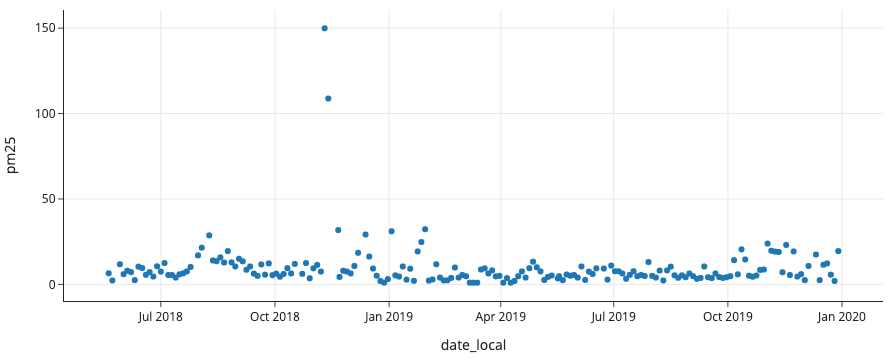

In [27]:
px.scatter(aqs, x='date_local', y='pm25',
          width=500, height=250)

We can see that the PM2.5 measurements don't go below 0. We also a large spike in PM2.5 around mid-November of 2018. This sensor is located in Sacramento, CA so we can check if there was a fire around that area?

Indeed, November 8, 2018 marks the start of the Camp Fire, the "deadliest and
most destructive wildfire in California history" {cite}`bureauCamp2018`. The fire
started just 80 miles north of Sacramento, so this AQS sensor captured the
dramatic spike in PM2.5.

We've cleaned and explored the data for one AQS sensor.
In the next section, we do the same for its co-located PurpleAir sensor.